# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Lab 3: kNN and Linear Regression

**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai<br/>
<hr style='height:2px'>

<a id=top></a>
## Learning Objectives

This will mark our first foray into modeling! Specifically, we'll look at linear regression  and k-nearest neighbors (kNN) regression.\
The goal of this lab is to set you up for success on HW2. To that end we'll look at:

- Inspecting your dataset. e.g., what are the data types? are my predictors categorical or quantitative? etc.
- Setting up our regression problem:
    - what do we want to predict? (i.e., the what is the response variable?)
    - selecting a predictor variable for your regression model
- Train-Test Split
- Fitting a simple, single variable regression model:
    - linear regression
        - accessing the learned parameters ($\beta_0$ & $\beta_1$)
        - checking model assumptions with residual plots
    - kNN
        - selecting the optimal $k$
        - visualizing the train/test loss as a function of $k$
- evaluating the models with MSE and $R^2$ metrics
- plotting predictions


### Using the `%load` Command
Cells with `# %load` allow you to quickly load pre-written code.

**You'll get the most out of the lab if attempt to write the code yourself.** But if you get stuck or feel like you are falling behind:

1. Uncomment the `# %load` line (`Ctrl + /` or `Cmd + /` on macOS).
2. Run the cell.

This brings in the correct code for that cell.

In [5]:
# %load snippets/imports.py
# imports also appear again in the notebook below
# when these libraries first get used
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from warnings import simplefilter
simplefilter('ignore', category=(FutureWarning, UserWarning))

## The Dataset

**The dataset is provided in the file** `data/bikeshare.csv`.

Our dataset was collected by the Capital Bikeshare program in Washington D.C (*source: [UCI repository](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)*). It contains over two years of data on the total number of bike rentals per day, as well as 10 attributes describing the day and its weather (see below for a description). 

The task is to build a regression model to **predict the total number of bike rentals in a given day** (known as the response variable) based on attributes about the day (known as the 'features' or 'predictors'). Such a forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city.

**Description of variables**

- season (1:winter, 2:spring, 3:summer, 4:fall) 
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise, extracted from https://dchr.dc.gov/page/holiday-schedules)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent, or relative outdoor, or real feel temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)
------------------------
- **count** (response variable i.e. total number of bike rentals on the day)

#### Take a look at the data!

In [6]:
# %load snippets/inspect.py
import pandas as pd
# load the data
df = pd.read_csv('data/bikeshare.csv')
# various ways of quick inspection
print("df.head()")
display(df.head())
print("df.info()")
display(df.info())
print("df.describe()")
display(df.describe())

df.head()


,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2,5,0,2,1,2,24.0,26.0,76.58,0.12,6073
1,4,12,0,2,1,1,15.0,19.0,73.38,0.17,6606
2,2,6,0,4,1,1,26.0,28.0,56.96,0.25,7363
3,4,12,0,0,0,1,0.0,4.0,58.63,0.17,2431
4,3,9,0,3,1,3,23.0,23.0,91.71,0.10,1996


df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       731 non-null    int64  
 1   month        731 non-null    int64  
 2   holiday      731 non-null    int64  
 3   day_of_week  731 non-null    int64  
 4   workingday   731 non-null    int64  
 5   weather      731 non-null    int64  
 6   temp         731 non-null    float64
 7   atemp        731 non-null    float64
 8   humidity     731 non-null    float64
 9   windspeed    731 non-null    float64
 10  count        731 non-null    int64  
dtypes: float64(4), int64(7)
memory usage: 62.9 KB


None

df.describe()


,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,6.519836,0.028728,2.997264,0.683995,1.395349,16.229822,18.885089,62.789357,0.190383,4552.354309
std,1.110807,3.451913,0.167155,2.004787,0.465233,0.544894,11.531101,10.278475,14.242923,0.077679,2021.971365
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-11.000000,-6.000000,0.000000,0.020000,22.000000
25%,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,6.000000,10.000000,52.000000,0.130000,3116.000000
50%,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,16.000000,20.000000,62.670000,0.180000,4575.000000
75%,3.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.000000,27.000000,73.020000,0.230000,6048.000000
max,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,39.000000,42.000000,97.250000,0.510000,10045.000000


#### Choosing a predictor

If we can only use one feature for predicting `count`, which should we choose?

for example, what is the relationship between `humidity` and `count`?

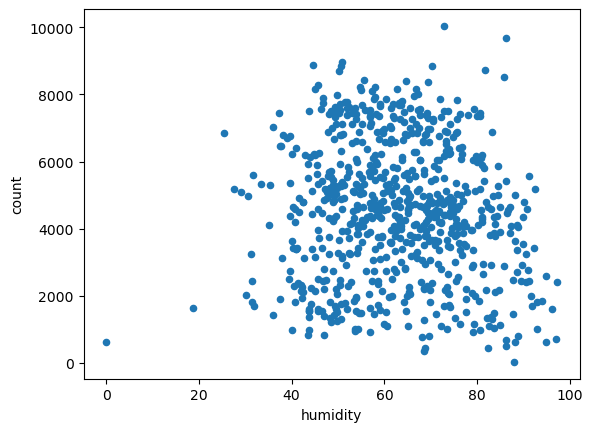

In [7]:
# %load snippets/quick_scatter.py
df.plot(x='humidity', y='count', kind='scatter');

**Why not look at all features?**

First get a list of all the potential predictor columns and see how many there are

In [12]:
# %load snippets/predictor_cols.py
# Get a list of all columns excluding the response 'count'
cols = df.drop('count', axis=1).columns

# There are 10 features
# This is a nice even number for plotting in a grid with 2 columns
print(f"There are {len(cols)} potential predictors")

There are 10 potential predictors


Now, with the help of `plt.subplots()`, create a grid of scatter plots showing the relationship between each potential predictor and `count`.

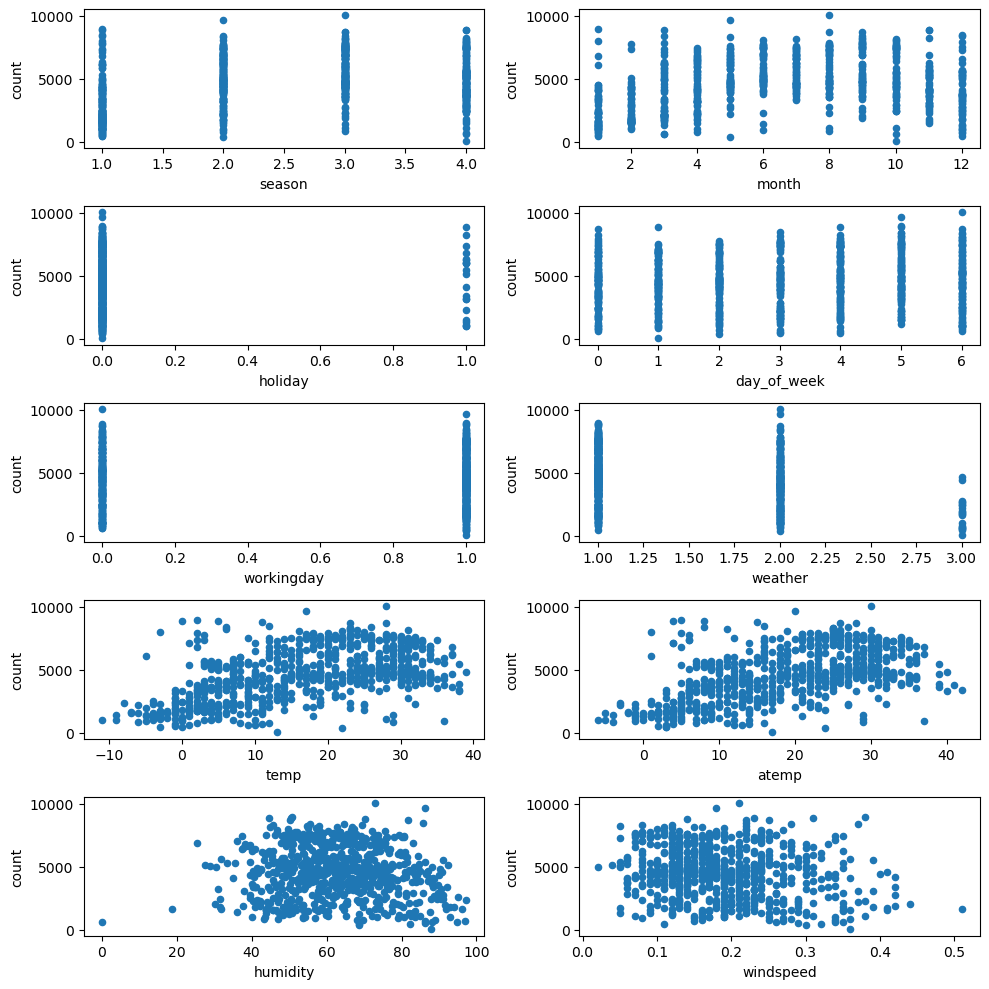

In [13]:
# %load snippets/scatter_subplots.py
import matplotlib.pyplot as plt
# Create a grid of axes
fig, axes = plt.subplots(nrows=len(cols)//2, ncols=2, figsize=(10,10))
# flatted the axes array to 1D -> we don't have to deal with the rows and columns -> index 0 through 9
axes = axes.ravel() # using ravel means we don't need to iterate over rows and columns
# iterate over pairs of column names and axes -> zip together predictors with axes
for c, ax in zip(cols, axes):
    # Use pandas' plot functionality
    df.plot(x=c, y='count', kind='scatter', ax=ax)
# add some padding between subplots
plt.tight_layout()

Seaborn's `pairplot` method allows us to do something very similar with very little code.

But with a DataFrame with $M$ columns you get a huge plot of all $M\times M$ relationships! We can use the `x_vars` and/or `y_vars` arguments to list only those variables to include on each axis.

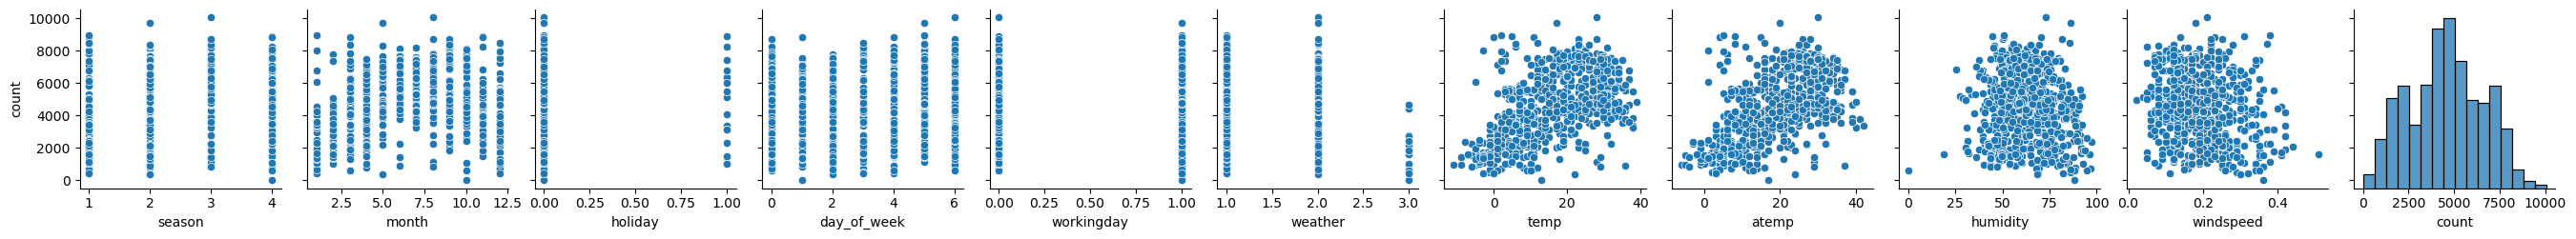

In [15]:
# %load snippets/pairplot.py
# x_vars and y_vars args help slim it down
sns.pairplot(df, y_vars=['count']);

Another approach is to visualize the correlation between each predictor.

We can get the correlation coefficients with the `corr()` DataFrame method and then use Seaborn's `heatmap()` to vizualize the values.

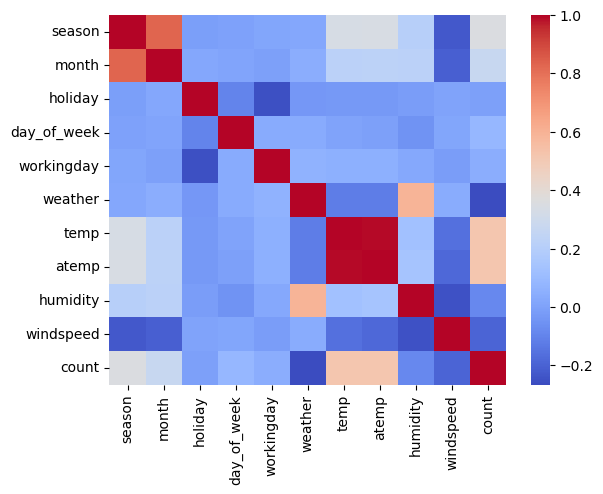

In [18]:
# %load snippets/corr_heatmap.py
# visualizing the correlation between all variables
import seaborn as sns
sns.heatmap(df.corr(), cmap='coolwarm'),;

**Q:** 🤔 Is there a way we could change the default heatmap to make it easier to interpret?

It looks like `temp` is the winner (at least if we plan to use a linear model).

### We have our feature. Now what?

Now let's separate our chosen feature and the response variable into `x` and `y`.

You may want to check the data types of your new variables so you know what you're working with.

In [20]:
# %load snippets/x_and_y.py
x = df[['temp']]
y = df['count']
type(x), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

Check the shapes!

In [22]:
# %load snippets/shape_check.py
x.shape, y.shape
# sklearn expects the second dimension

((731, 1), (731,))

SKLearn models expect the predictors, $X$, to be in the form of a matrix. That is, there should be a nexplicit 2nd dimension. One way to handle this requirement is to use the double-brackets when indexing into your DataFrame to so you get a DataFrame back (and not a Series). If you are dealing with a 1D Numpy array, you can add a second dimension with the `reshape` or `expand_dims` methods.

#### Train-Test Split

We might be tempted to jump right to model fitting, but hold your horses! ✋🐎

If we use all of our data for training we are then forced to *evaluate* the model on the same data it was trained on!

But we want some sense of how well the model will **generalize**. That is, how well it performs on previously unseen data.

A low loss on the training data does not gaurantee good generalization. The model may have fit to the idiosyncrasies of our *particular* training data (noise, outliers, etc.) that are not representative of the wider population of potential data points. This would be a case of the dreaded **overfitting**.

So let's split our dataset into two pieces. A **train set** which we will use to fit the model, and a **test set** used for evaluating the model after fitting.

We'll be using a lot of classes and methods from the [sklearn](https://scikit-learn.org/stable/index.html) library both for our models themselves as well as helper functions for splitting and metrics. 

SKLearn functions and classes are grouped into different modules within the library. Search the [sklearn documentation](https://scikit-learn.org/stable/modules/classes.html) for "train test split" in order to see what module the relevent function resides in. This will tell us how we can import it! You can of course all read the full documentation on the function itself there.

In [24]:
# %load snippets/import_ttsplit.py
from sklearn.model_selection import train_test_split

It is important to shuffle the data (`shuffle=True` by default) to ensure a random sample for the test data.

Setting the `random_state` allows for reproducible results, ensuring we get the same split each time the code is run.

In [28]:
# %load snippets/split_x_y.py
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, shuffle=True, random_state=209)

Again, inspecting shapes can be helpful if you aren't sure you named the output correctly.

In [29]:
# %load snippets/split_shapes.py
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((584, 1), (147, 1), (584,), (147,))

We can also visually inspect that the split was random.

Create a scatter plot of temp vs count where train and test data are given different colors.

You should always use a **legend** to designate the meaning of each color. Also, adjusting the **alpha** value can be helpful to see where points are densly clustered.

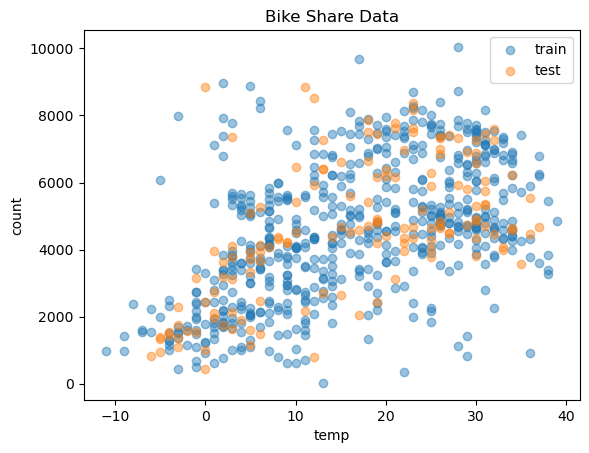

In [31]:
# %load snippets/split_scatter.py
plt.scatter(x_train, y_train, alpha=0.45, label='train')
plt.scatter(x_test, y_test, alpha=0.45, label='test')
plt.xlabel('temp')
plt.ylabel('count')
plt.title('Bike Share Data')
plt.legend();

### Simple Linear Regression

Import the `LinearRegression` class from sklearn's `linear_model` module.

In [38]:
# %load snippets/import_linreg.py
from sklearn.linear_model import LinearRegression # Linear Regression is a class

Fit a linear regression (on the train data of course!)

In [42]:
# %load snippets/fit_linreg.py
lr = LinearRegression().fit(x_train, y_train)
lr.fit(x_train, y_train)

LinearRegression()

Inspect the learned model parameters.

In [45]:
# %load snippets/linreg_params.py
lr.intercept_, lr.coef_
# intercept is bias; coef spits out array

(np.float64(3101.4328702768526), array([88.55680006]))

We can get the same model parameters using the linear algebra Pavlos showed in lecture.\
$$\beta = (X^{\top}X)^{-1}X^{\top}Y$$

Just remember that we actually need to augment our $x$ vector into a matrix with a column of ones if we want an intercept ($\beta_0$) term (consult the lecture 5 slides for details).

We can can store the augmented `x_train` as `X`. There are many ways to do this. One is to use a combination of `np.ones_like()` and `np.hstack()`.

In [47]:
# %load snippets/aug_x.py
import numpy as np
X = np.hstack((np.ones_like(x_train), x_train))
X

array([[ 1., 18.],
       [ 1., 33.],
       [ 1.,  2.],
       ...,
       [ 1., 31.],
       [ 1.,  2.],
       [ 1., 26.]])

Then it is just a matter of performing the matrix operations shown in the $\LaTeX$ above!

Compare the resulting $\beta$ values to the ones returned by SKLearn.

In [49]:
# %load snippets/linreg_linalg.py
betas = np.linalg.inv(X.T@X)@X.T@y_train
betas
# there might be some problems with the inverse!

array([3101.43287028,   88.55680006])

#### Model Evaluation

Let's calculate the train MSE. This will require predictions. You get these by calling the model's `predict` method on the appropriate data.

First, calculate the MSE by hand...

In [52]:
# %load snippets/mse_scratch.py
y_hat_train = lr.predict(x_train)
((y_train - y_hat_train)**2).mean()

np.float64(3054019.3409423027)

...then again but this time with the help of sklearn's `mean_squared_error` method from the `metrics` module.

In [54]:
# %load snippets/mse_skl.py
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, y_hat_train)

np.float64(3054019.3409423027)

Now calculate the test MSE!

In [56]:
# %load snippets/mse_test.py
y_hat_test = lr.predict(x_test)

mean_squared_error(y_test, y_hat_test)

np.float64(2757704.6531113614)

Are these good or bad MSEs? It is hard to make that kind of judgement given that they depend on the **scale of the response variable.**

Instead, we can use the **$R^2$ score** which compares out model to a baseline model which always predits the mean response value.

Recall that $R^2 = 1 - \frac{\text{unexplained variation}}{\text{total variation}}$

Calculate the $R^1$ score on the test data. First by hand...

In [58]:
# %load snippets/r2_scratch.py
total_var = sum((y_test.mean() - y_test)**2)
unexp_var = sum((y_test - y_hat_test)**2)
1 - (unexp_var/total_var)

0.3243922934535707

...and again using the `r2_score` metric from sklearn.

In [60]:
# %load snippets/r2_skl.py
from sklearn.metrics import r2_score

r2_score(y_test, y_hat_test)

0.3243922934535707

Sklearn models ('estimators' in their parlance) have a standardized API which include common methods like `fit` and `predict`.

There is also a `score` method which will return a (model dependant) metric when given an $x$ and $y$. This metric happens to be the $R^2$ for both the `LinearRegression` and `KNeighborsRegressor` estimators.

Under the hood it is making predictions and then comparing those to the true $y$ values.

Use your model's `score` to get the $R^2$ score on the test data.

In [62]:
# %load snippets/linreg_score.py
lr.score(x_test, y_test)

0.3243922934535707

#### D.R.Y: Don't Repeat Yourself

Let's make a function to help calculate metrics for our models since we will do this multiple times in the notebook.

Complete the `get_metrics` function so it returns a dictionary containing the requested information about the input model.

In [66]:
# %load snippets/metrics_helper.py
def get_metrics(model, name: str, data: tuple) -> dict:
    '''
    Parameters
    ----------
    model : (sklearn estimator) This is your fitted sklearn model
    name : (str) A name to represent your model
    data : (tuple) contains train and test split for x and y

    Returns:
    metrics : (dict) should have entries for:
             name, train_mse, test_mse, r2_train, and r2_test
    '''
    x_train, x_test, y_train, y_test = data
    # your code here
    d = {}
    y_hat_train = model.predict(x_train)
    y_hat_test = model.predict(x_test)
    d['name'] = name
    d['train_mse'] = mean_squared_error(y_train, y_hat_train)
    d['test_mse'] = mean_squared_error(y_test, y_hat_test)
    d['r2_train'] = r2_score(y_train, y_hat_train)
    d['r2_test'] = r2_score(y_test, y_hat_test)
    return d

We'll keep track of our models' results using a list of dictionaries.

Use `get_metrics` to calculate the metrics for your linear regression model and add it to a list called `results`.

In [67]:
# %load snippets/linreg_results.py
data = (x_train, x_test, y_train, y_test)
results = [get_metrics(lr, 'Linear Regression', data)]
results
# easy to create a dataframe from a dictionary

[{'name': 'Linear Regression',
  'train_mse': np.float64(3054019.3409423027),
  'test_mse': np.float64(2757704.6531113614),
  'r2_train': 0.2517207811009071,
  'r2_test': 0.3243922934535707}]

This also allows us to display the results in a nice DataFrame. OooOoo!

Use `results` to create a DataFrame.

In [69]:
# %load snippets/linreg_results_df.py
pd.DataFrame(results)

,name,train_mse,test_mse,r2_train,r2_test
0,Linear Regression,3.054019e+06,2.757705e+06,0.251721,0.324392


####  Visualizing our model

The metrics above give us information about the model's performance. But a picture can also help our understanding.

Let's create a plot showing the train data, test data, and model predictions *for all values of the predictor in the range of the dataset*.

First, use `np.linspace` to create an array of equally spaced values spanning the range of temperatures observed in the entire dataset. Store these values in `x_lin`.

In [71]:
# %load snippets/x_lin.py
# create a range of values to predict on
x_lin = np.linspace(x.min(), x.max(), 1000)

# If the model was fit on data with a names for the predictor(s)
# (e.g., a Series or DataFrame)
# and is then asked to predict on data with no names
# (e.g., a numpy array)
# it will complain!
# These warnings are harmless but ugly :(
# One way to get it to shush is to turn the data into a type
# that does include a name for the predictor(s)
x_lin = pd.DataFrame(x_lin, columns=['temp'])
x_lin.head()

,temp
0,-11.00000
1,-10.94995
2,-10.89990
3,-10.84985
4,-10.79980


Now the actual plot!

Overlay the model's prediction line on top of a scatter plot of the train and test data (you can recycle that plotting code form earlier).

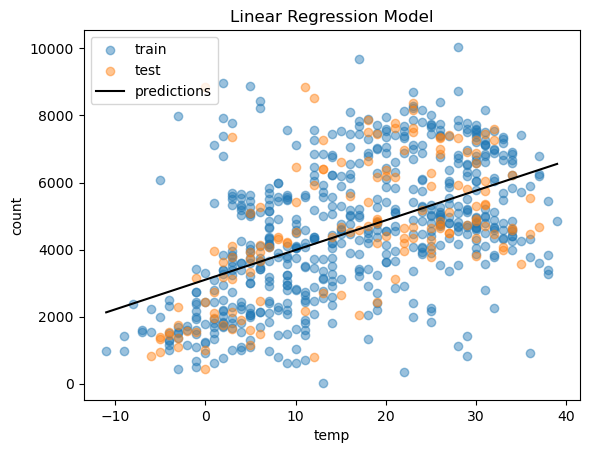

In [73]:
# %load snippets/linreg_pred_plot.py
y_pred = lr.predict(x_lin)
plt.scatter(x_train, y_train, alpha=0.45, label='train')
plt.scatter(x_test, y_test, alpha=0.45, label='test')
plt.plot(x_lin, y_pred, c='k', label='predictions');
plt.xlabel('temp')
plt.ylabel('count')
plt.title('Linear Regression Model')
plt.legend();

#### What about the assumptions we make when using a linear model?

Pavlos told us in lecture that two of our assumptions when using a linear model are that (1) the variance of the residuals is constant and (2) the residuals are normally distributed. Let's check those assumptions.

First, we'll check for constant variance of the residuals. Recall that the residuals are the difference between the true value and the predicted value.

Calculated the residuals on the test data and store them in `resids`.

In [75]:
# %load snippets/resids.py
y_hat_test = lr.predict(x_test)
resids = y_test - y_hat_test

Create a scatter plot of the residuals against the predictor. It can be helpful to add a horizontal line at 0 

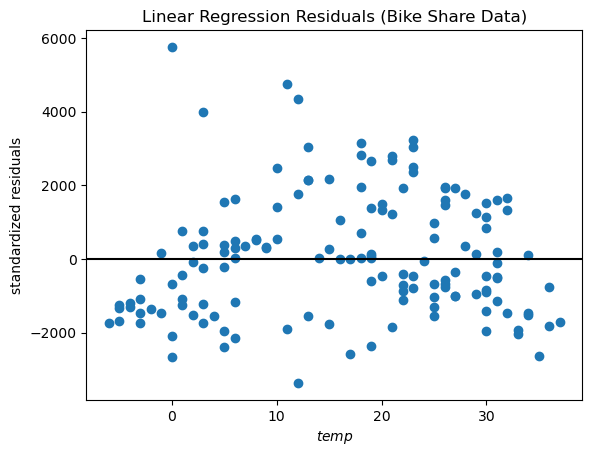

In [77]:
# %load snippets/resids_plot.py
plt.scatter(x_test, resids)
plt.axhline(0, c='k')
plt.ylabel('standardized residuals')
plt.title('Linear Regression Residuals (Bike Share Data)')
plt.xlabel('$temp$');

There seems to be a slight 'hump' in the middle...

Next, check that residuals are normally distributed. We can use a histogram for this.

In [ ]:
# %load snippets/resids_dist.py


Hmm, not quite symmetrical either.

If we look back at our plot of the training data we can see there is a slight curve in the trend. We might have expected this: bike riding increases as the tempature increases, but only up to a point. At some point the heat makes people less inclined to go for a ride! 🚴‍♀️🌞

Perhaps a non-linear model like kNN may be better suited to model the relationship between `temp` and `count`.

### kNN

Fit a kNN model using the `sklearn.neighbors.KNeighborsRegressor` class. To start, let's use `n_neighbors=10`.

In [81]:
# %load snippets/fit_k10.py
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=10).fit(x_train, y_train) # Regressor is a constructor

Unlike linear regression, fitting kNN does not calculate any parameters. It simply stores the training data in an efficient way for calculating pair-wise distances at prediction time.

$k$ is a *hyperparamter*. Hyperparameters are *not* learned from the data. Instead, they are set by the practitioner (like you!) and define the learning/prediction algorithm that will follow. We'll talk more about hyperparameters as the course continues.

#### Metrics

Use `get_metrics` to calculate the kNN model's metrics, append them to `results`, and display `results` as a DataFrame.

In [83]:
# %load snippets/k10_results.py
results.append(get_metrics(knn, 'kNN (k=10)', data))

pd.DataFrame(results)

,name,train_mse,test_mse,r2_train,r2_test
0,Linear Regression,3.054019e+06,2.757705e+06,0.251721,0.324392
1,kNN (k=10),2.832597e+06,2.673262e+06,0.305972,0.345080


### Choosing $k$

OK, great! But $k=10$ was an arbitrary choice. Why not choose the $k$-value that minimizes the test MSE?

We'll fit kNN regressors on a range of k values and inspect the loss as a function of $k$.

Let's try all 1 through 100 for our potential $k$ values. We should store the train and test MSEs for each model.

In [86]:
# %load snippets/all_k_mses.py
# range of candidate k values
ks = range(1, 101)
# lists to store train and test MSEs
train_mses = []
test_mses = []
# fit a model for each k and record MSEs
for k in ks:
    cur_knn = KNeighborsRegressor(n_neighbors=k).fit(x_train, y_train)
    train_mses.append(mean_squared_error(y_train, cur_knn.predict(x_train)))
    test_mses.append(mean_squared_error(y_test, cur_knn.predict(x_test)))

Now let's plot the the losses as a function of $k$ and identify the best $k$-value based on the test loss.

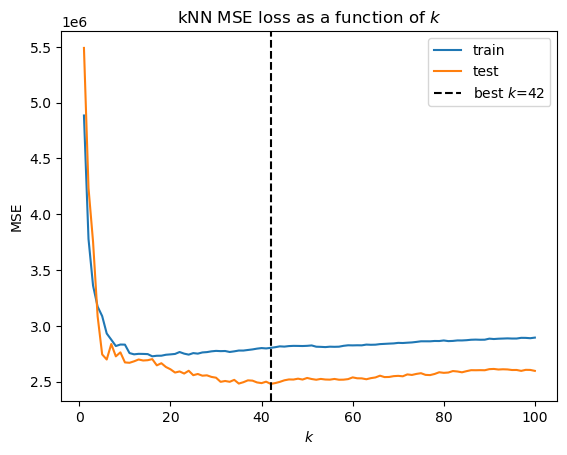

In [88]:
# %load snippets/mse_vs_k_plot.py
# argmin gives the index of the lowest test MSE
best_idx = np.argmin(test_mses)
# which we cna use to select the k that corresponds to that minimum loss
best_k = ks[best_idx]

plt.plot(ks, train_mses, label='train')
plt.plot(ks, test_mses, label='test')
plt.axvline(best_k, c='k', ls='--', label=rf'best $k$={best_k}')
plt.xlabel(r'$k$')
plt.ylabel('MSE')
plt.title('kNN MSE loss as a function of $k$')
plt.legend();

**Q:** Might we be justified in choosing a $k$ that does not produce the lowest test score? 🤔

**Q:** Do you have any reason to be skeptical about using the test score to determine the best $k$? 🤔

#### Final metric comparison

Fit the best kNN model, calculate and append its metrics to `results`, and again display all model results as a DataFrame.

In [90]:
# %load snippets/fit_best_k.py
best_knn = KNeighborsRegressor(n_neighbors=best_k).fit(x_train, y_train)

In [92]:
# %load snippets/best_k_results.py
results.append(get_metrics(best_knn, f'kNN (k={best_k})', data))

In [94]:
# %load snippets/final_results.py
pd.DataFrame(results)

,name,train_mse,test_mse,r2_train,r2_test
0,Linear Regression,3.054019e+06,2.757705e+06,0.251721,0.324392
1,kNN (k=10),2.832597e+06,2.673262e+06,0.305972,0.345080
2,kNN (k=42),2.803686e+06,2.480700e+06,0.313056,0.392255


### Plotting $k$-NN Predictions

Now let's plot our kNN model's predictions. This can be trickier than plotting the linear regression predictions!

You will again need to use something like `np.linspace` to generate inputs for the predictions. Remember that the kNN predictions should look like a step function; there should be no diagonal sections. If you see diagonal portions of the prediction line then you are not using a sufficient number of points in your linspace.

Feel free to use the `x_lin` you defined earlier when making the linear regression prediction plots. You can also reuse the data scatter plot code (we probably should have written a function!)

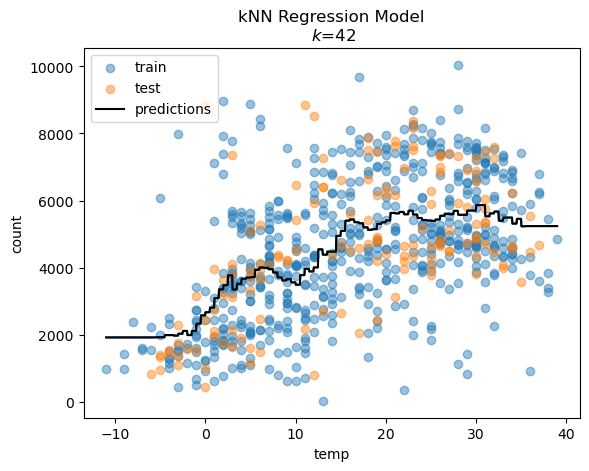

In [96]:
# %load snippets/plot_best_k_pred.py
# generate x values to predict on as before (for completeness)
x_lin = np.linspace(x.min(), x.max(), 1000)
x_lin = pd.DataFrame(x_lin, columns=['temp'])
x_lin.head()

# get predictions to plot
y_pred = best_knn.predict(x_lin)

# plot!
plt.plot(x_lin, y_pred)
plt.scatter(x_train, y_train, alpha=0.45, label='train')
plt.scatter(x_test, y_test, alpha=0.45, label='test')
plt.plot(x_lin, y_pred, c='k', label='predictions');
plt.xlabel('temp')
plt.ylabel('count')
plt.title(f'kNN Regression Model\n $k$={best_k}')
plt.legend();

### Prediction plots for multiple choices of $k$

How would you go about creating a visualization comparing the predictions of several different kNN models, each using different value of $k$? For example, let's try values 1, 2, 4, 8, 16, 32, 64, and 128. 

First, create a list of candidate $k$ values called `ks`.

In [98]:
# %load snippets/candidate_ks.py
ks = [2**x for x in range(0,8)]

Next, fit a KNN model for each candidate $k$ and store their predictions in a list called `all_preds`.

**Q:** What should we predict on? 🤔 (Remember that we are making a plot!)

In [100]:
# %load snippets/get_all_k_preds.py
# 'fit' a model for each k and collect the predictions
all_preds = []
for k in ks:
    preds = KNeighborsRegressor(n_neighbors=k).fit(x_train, y_train).predict(x_lin)
    all_preds.append(preds)

The number of candidate $k$ values is even, so let's create a grid of prediction plots with 2 columns.

(Reviewing the manual pairplot we did way back in the beginning of the notebook may help here).

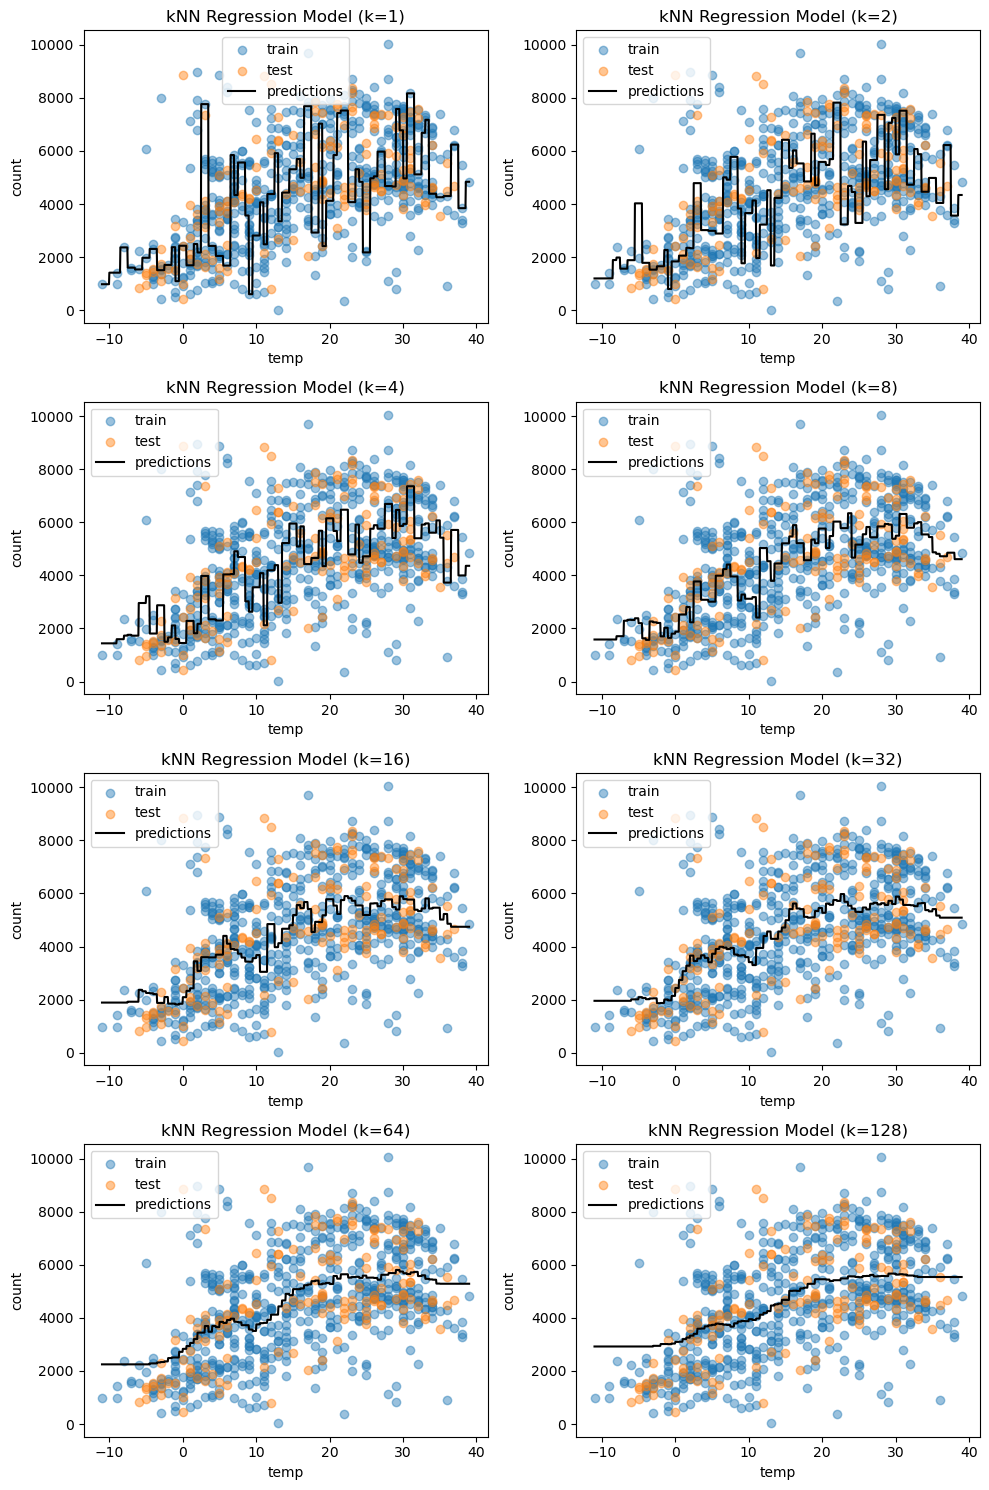

In [102]:
# %load snippets/plot_all_k_preds.py
fig, axes = plt.subplots(nrows=len(all_preds)//2, ncols=2, figsize=(10,15))
axes = axes.ravel()
# We can zip as many iterables as we like together!
for k, cur_preds, ax in zip(ks, all_preds, axes):
    ax.scatter(x_train, y_train, alpha=0.45, label='train')
    ax.scatter(x_test, y_test, alpha=0.45, label='test')
    ax.plot(x_lin, cur_preds, c='k', label='predictions');
    ax.set_xlabel('temp')
    ax.set_ylabel('count')
    ax.set_title(f'kNN Regression Model (k={k})')
    ax.legend();
    
plt.tight_layout()

As expected, for low values of $k$ the prediction line is complex and jagged. It smooths at as $k$ increase because more neighbors are considered for each prediction.

**Bonus:** Try changing the `random_state` in the call to `train_test_split` and see how it affects your results, both in regards to the metrics and the choice of best $k$. It seems our results are sensitive to the random test split we received! This motivates the idea of **cross-validation** which will be covered next week!

**The End!** 🎉